### Imports

In [1]:
from collections import defaultdict
from datetime import datetime
from glob import glob
import json
import math
import os
from pprint import pprint

from datasets import load_from_disk
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 500
import scipy as sp
import seaborn as sns
sns.set_style("white")
from tqdm.notebook import tqdm

### Helpful functions, variables

In [2]:
def compress_binary_array(arr):
    """ compress binary array (e.g., array of incorrect / correct labels) by
        converting consecutive subsequences of 0s / 1s into single 0 / 1 """
    return arr if arr.size == 0 else arr[np.insert(np.diff(arr) != 0, 0, True)]


def key(fname):
    """ key for sorting results files based on checkpoints step """
    dirname = os.path.basename(os.path.dirname(fname))
    for part in dirname.split("-"):
        if "step" in part:
            return int(part.replace("step", ""))
    raise RuntimeError("'step' not found in dirname")
               
# ParaRel relations, filename pattern for OLMo prediction results
relations = ["p17", "p27", "p36", "p127", "p131", "p138", "p176",
             "p178", "p276", "p495", "p1376", "p1412"]

# index of main template for each relation
template_index = {
    "p17": 0,
    "p27": 2,
    "p36": 0,
    "p127": 0,
    "p131": 0,
    "p138": 1,
    "p176": 0,
    "p178": 0,
    "p276": 1,
    "p279": 0,
    "p495": 2,
    "p1376": 0,
    "p1412": 0
}

# majority label baseline for each relation
majority_baseline = {
    "p17":   79. / 928,
    "p27":   97. / 966,
    "p36":   10. / 681,
    "p127":  63. / 687,
    "p131":  30. / 881,
    "p138":  11. / 604,
    "p176":  100. / 961,
    "p178":  164. / 580,
    "p276":  44. / 877,
    "p495":  128. / 907,
    "p1376": 4. / 216,
    "p1412": 234. / 965,
}

### Get correctness labels for all instances (for all relations) and all steps

In [3]:
labels = np.load(f"{os.environ['HOME']}/projects/pretrain-intervention/results/eval/"
                 "labels_olmo2_1b_retr_step_500_to_10000_pararel_12rel.npz")

correct_labels = labels["labels"]
relation_labels = labels["dataset_labels"]
ckpt_steps = labels["steps"]

# get per-relation accuracies
accuracies = dict()
for rel in relations:
    idxs = np.where(relation_labels == rel)[0]
    accuracies[rel] = np.mean(correct_labels[idxs, :], axis=0)

labels shapes:
{'dataset_labels': (9253,), 'labels': (9253, 20), 'steps': (20,)}


### Plot performance of OLMo-2-0425-1B on all ParaRel relations

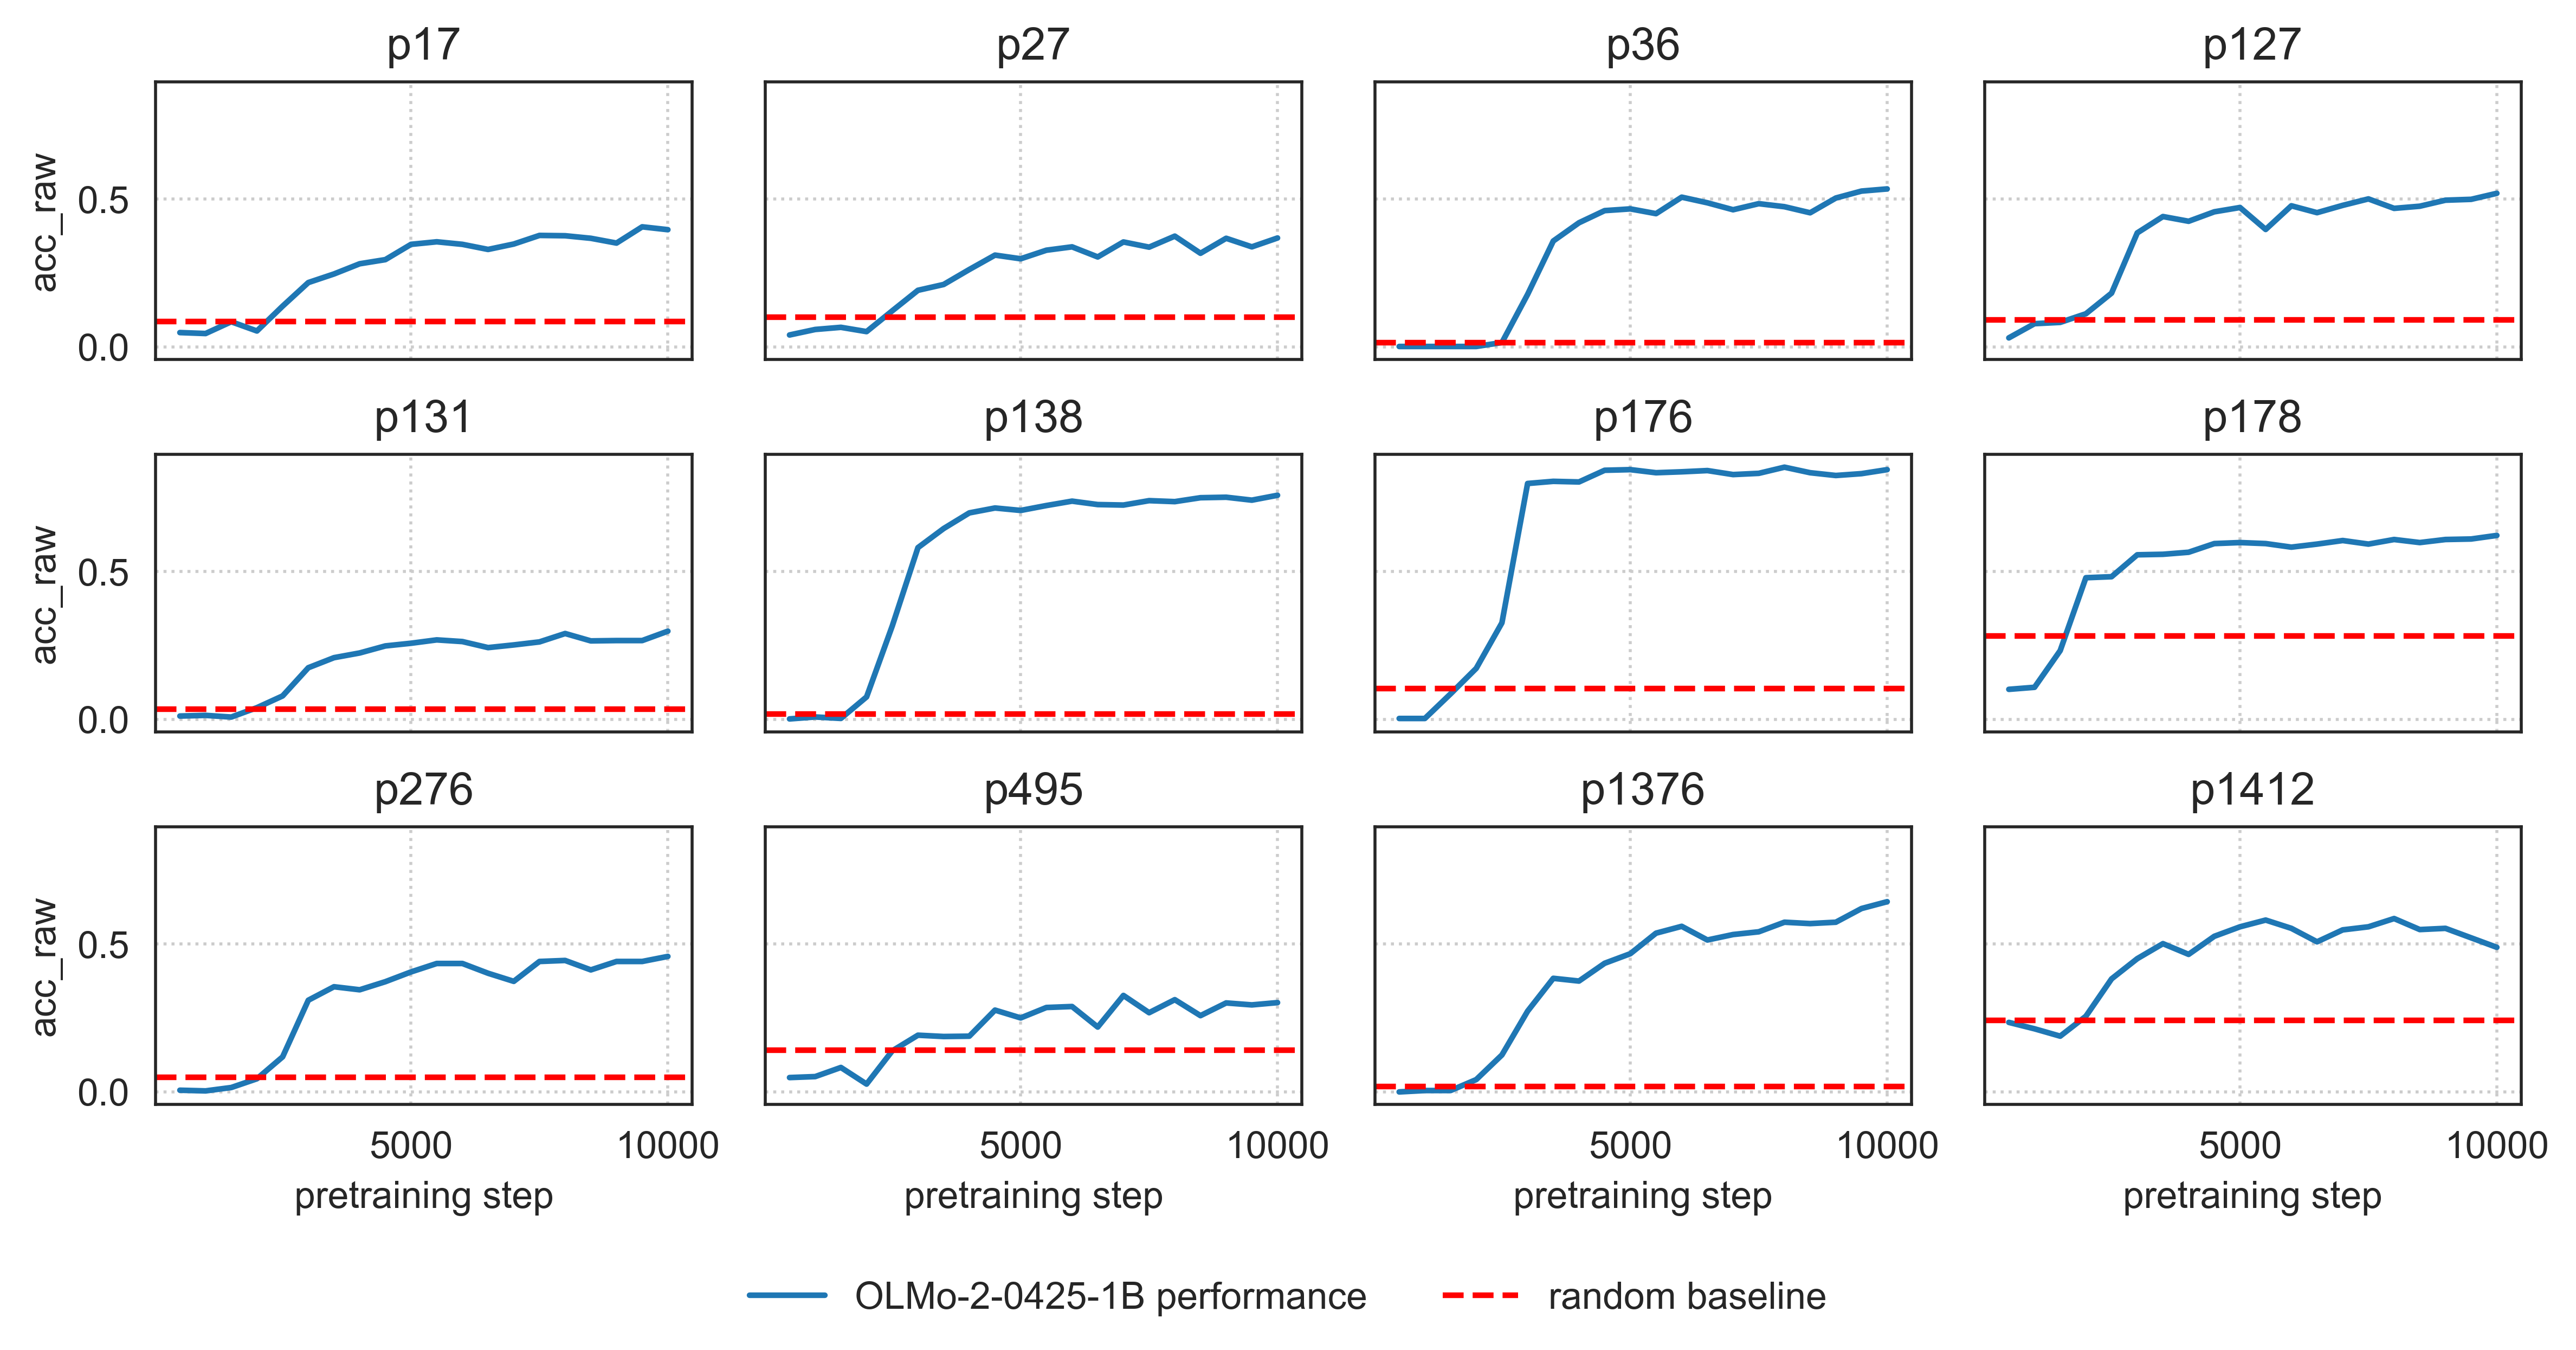

In [4]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True,
                       figsize=(9.7, 5))

for i, rel in enumerate(relations):
    r, c = np.unravel_index(i, ax.shape)
    ax[r, c].plot(ckpt_steps, accuracies[rel], label="OLMo-2-0425-1B performance")
    ax[r, c].axhline(majority_baseline[rel], linestyle="dashed", color="red",
                     label="random baseline")
    ax[r, c].grid(linestyle="dotted")
    if r == ax.shape[0] - 1:
        ax[r, c].set_xlabel("pretraining step")
    if c == 0:
        ax[r, c].set_ylabel("acc_raw")
    ax[r, c].set_title(rel)

fig.legend(handles=ax[0, 0].lines, loc="lower center", ncol=2, frameon=False)
plt.tight_layout()
plt.subplots_adjust(bottom=0.175)
plt.show()

### Get sparse matrices of {term pair, document} occurrences and post-process them

Sparse {term pair, document} matrices are separated by relation and grouped by 1,000 data batches each. We want to stack across all relations and split them into groups of 500 data batches each (i.e., one per saved intermediate checkpoint for OLMo-2-1B). We do this via the following series of steps:
1. Load sparse {term pair, document} matrices for every relation and 1,000-data batch group, stack across relations.
2. Load doc info files for each 1,000-data batch group.
3. Use doc info files to find document index for each 500-data batch split, split larger sparse matrices accordingly.

In [6]:
# get {term pair, doc} matrices, sanity check relation labels
term_pair_doc_pattern = (f"{os.environ['HOME']}/projects/pretrain-intervention/results/olmo-mix-1124/"
                         "term_pair_doc_matrices/pararel_patterns_{rel}/{ckpt}.npz")

pair_doc_matxs_1k = dict()
relation_labels_ = list()
for i in range(1, 6):
    matrices = list()
    for rel_idx, rel in enumerate(relations):
        matrix = sp.sparse.load_npz(term_pair_doc_pattern.format(rel=rel, ckpt=f"{i:03d}"))
        matrices.append(matrix)
        if i == 1:
            relation_labels_.extend([rel] * matrix.shape[0])
    pair_doc_matxs_1k[1000 * i] = sp.sparse.vstack(matrices)
relation_labels_ = np.array(relation_labels_)
assert all(relation_labels == relation_labels_), "relation labels do not match"
print("pair_doc_matxs_1k shapes:")
pprint({k : v.shape for k, v in pair_doc_matxs_1k.items()})

# get doc info files for all 1,000-step data batches
doc_info_pattern = (f"{os.environ['HOME']}/projects/pretrain-intervention/results/olmo-mix-1124/"
                    "doc_info/allenai-OLMo-2-0425-1B/{ckpt}.npy")

doc_info = dict()
for i in range(1, 6):
    info = np.load(doc_info_pattern.format(ckpt=f"{i:03d}"))
    doc_info[1000 * i] = info
print("doc_info shapes:")
pprint({k : v.shape for k, v in doc_info.items()})

# use doc info files to split {term pair, doc} matrices into groups of 500 steps
pair_doc_matxs = dict()
for i in range(1, 6):
    start_idxs = [0] + [np.where(doc_info[1000 * i][:, 0] == 500)[0][0]] + [len(doc_info[1000 * i])]
    for j, (start, end) in enumerate(zip(start_idxs[:-1], start_idxs[1:])):
        pair_doc_matxs[1000 * (i - 1) + 500 * (j + 1)] = pair_doc_matxs_1k[1000 * i][:, start : end]
print("pair_doc_matxs shapes:")
pprint({k : v.shape for k, v in pair_doc_matxs.items()})

# get co-occurrence counts (sum across columns of {term pair, doc} matrices)
coocc_counts = list()
for step in list(range(500, 5100, 500)):
    coocc_counts.append(np.sum(pair_doc_matxs[step], axis=1).A1.flatten())
coocc_counts = np.vstack(coocc_counts).T
print("coocc_counts.shape:", coocc_counts.shape)

pair_doc_matxs_1k shapes:
{1000: (9253, 2180661),
 2000: (9253, 2179275),
 3000: (9253, 2179547),
 4000: (9253, 2179581),
 5000: (9253, 2179876)}
doc_info shapes:
{1000: (2180661, 4),
 2000: (2179275, 4),
 3000: (2179547, 4),
 4000: (2179581, 4),
 5000: (2179876, 4)}
pair_doc_matxs shapes:
{500: (9253, 1088785),
 1000: (9253, 1091876),
 1500: (9253, 1090212),
 2000: (9253, 1089063),
 2500: (9253, 1089162),
 3000: (9253, 1090385),
 3500: (9253, 1091084),
 4000: (9253, 1088497),
 4500: (9253, 1089017),
 5000: (9253, 1090859)}
coocc_counts.shape: (9253, 10)


### Get sparse matrices of term-document occurrences and post-process them

Just like the sparse {term pair, document} matrices, the sparse term-document matrices are separated by relation and grouped by 1,000 data batches each. We want to stack across all relations and split them into groups of 500 data batches each (i.e., one per saved intermediate checkpoint for OLMo-2-1B). We do this via the following series of steps:
1. Load sparse term-document matrices for every relation and 1,000-data batch group.
2. Load doc info files for each 1,000-data batch group.
3. Use doc info files to find document index for each 500-data batch split, split larger sparse matrices accordingly.

In [7]:
term_doc_pattern = (f"{os.environ['HOME']}/projects/pretrain-intervention/results/olmo-mix-1124/"
                    "term_doc_matrices/pararel_patterns_{rel}/{ckpt}.npz")

# get term-doc matrices
term_doc_matxs_1k = defaultdict(dict)
for i in range(1, 6):
    ckpt = f"{i:03d}"
    matrices = list()
    for rel_idx, rel in enumerate(relations):
        term_doc_matxs_1k[1000 * i][rel] = sp.sparse.load_npz(term_doc_pattern.format(rel=rel, ckpt=ckpt))

# use doc info files to split term-doc matrices into groups of 100 steps
term_doc_matxs = defaultdict(dict)
for i in tqdm(range(1, 6)):
    start_idxs = [0] + [np.where(doc_info[1000 * i][:, 0] == 500)[0][0]] + [len(doc_info[1000 * i])]
    for j, (start, end) in enumerate(zip(start_idxs[:-1], start_idxs[1:])):
        for rel in relations:
            term_doc_matxs[1000 * (i - 1) + 500 * (j + 1)][rel] = term_doc_matxs_1k[1000 * i][rel][:, start : end]

  0%|          | 0/5 [00:00<?, ?it/s]

### Get term list indices of entities for each instance, for each relation

In [17]:
# path to Huggingface format dataset for relation
dataset_pattern = (f"{os.environ['HOME']}/projects/pretrain-intervention/data/"
                   "huggingface/pararel_patterns_{rel}")

# path to text file with list of terms for relation
terms_file_pattern = (f"{os.environ['HOME']}/projects/pretrain-intervention/data/"
                      "search_terms/pararel_patterns_{rel}_train.txt")

term_idxs = dict()
for rel in tqdm(relations, desc="loading term lists"):
    dataset = load_from_disk(dataset_pattern.format(rel=rel))
    pairs = list(zip(list(map(str.strip, dataset["train"]["subject"])),
                     list(map(str.strip, dataset["train"]["object"]))))
    with open(terms_file_pattern.format(rel=rel), "r") as f:
        terms = list(map(str.strip, f.readlines()))
    term_idxs[rel] = [(terms.index(subj), terms.index(obj))
                      for subj, obj in pairs]

loading term lists:   0%|          | 0/12 [00:00<?, ?it/s]

### Get histogram of learned checkpoints across all relations

For each relation, find the instances that are "definitively learned", i.e., there exists a checkpoint where that instance is always incorrect before and always correct after (their correctness label is a step function). For these instances, keep counts of at which checkpoints they're learned for all relations.

In [20]:
learned_ckpts_all = list()
learned_idxs_all = list()

# get learned checkpoint for instances that are definitively learned
# (only incorrect up to a checkpoint, then only correct after)
for i, row in enumerate(correct_labels):
    compressed = compress_binary_array(row)
    if len(compressed) == 2 and np.allclose(compressed, [0, 1]) or \
        len(compressed) == 1 and np.allclose(compressed, [1]):
        learned_ckpts_all.append(np.where(row == 1)[0][0])
        learned_idxs_all.append(i)

learned_ckpts_all = np.array(learned_ckpts_all)
learned_idxs_all = np.array(learned_idxs_all)

# restrict to those learned before step 5000
idx_limit = 10
idxs = np.where(learned_ckpts_all < idx_limit)[0]
learned_ckpts = learned_ckpts_all[idxs]
learned_idxs = learned_idxs_all[idxs]

binned_learned_ckpts = np.bincount(learned_ckpts, minlength=idx_limit)

print("learned_ckpts.shape:", learned_ckpts.shape)
print("learned_idxs.shape:", learned_idxs.shape)
print("binned_learned_ckpts.shape:", binned_learned_ckpts.shape)

# for each learned checkpoint, get the number of learned instances that
# have non-zero co-occurrence in the previous checkpoint
learned_nonzero_counts = np.zeros_like(binned_learned_ckpts)
learned_nonzero_count_idxs = list()
for i in range(len(binned_learned_ckpts)):
    idxs = np.where(learned_ckpts == i)[0]
    nonzero_idxs = np.nonzero(coocc_counts[learned_idxs[idxs], i])[0]
    learned_nonzero_counts[i] = len(nonzero_idxs)
    learned_nonzero_count_idxs.append(learned_idxs[idxs][nonzero_idxs])
    assert np.all(coocc_counts[learned_nonzero_count_idxs[-1], i] > 0)
    assert np.all(np.isin(learned_nonzero_count_idxs[-1], learned_idxs))

learned_ckpts.shape: (2623,)
learned_idxs.shape: (2623,)
binned_learned_ckpts.shape: (10,)


### Plot histogram of learned checkpoints across all relations (first 5000 steps)

[  79   30  186  319  569 1063  232   87   44   14]
[ 62  23 126 192 280 607 121  57  25   7]


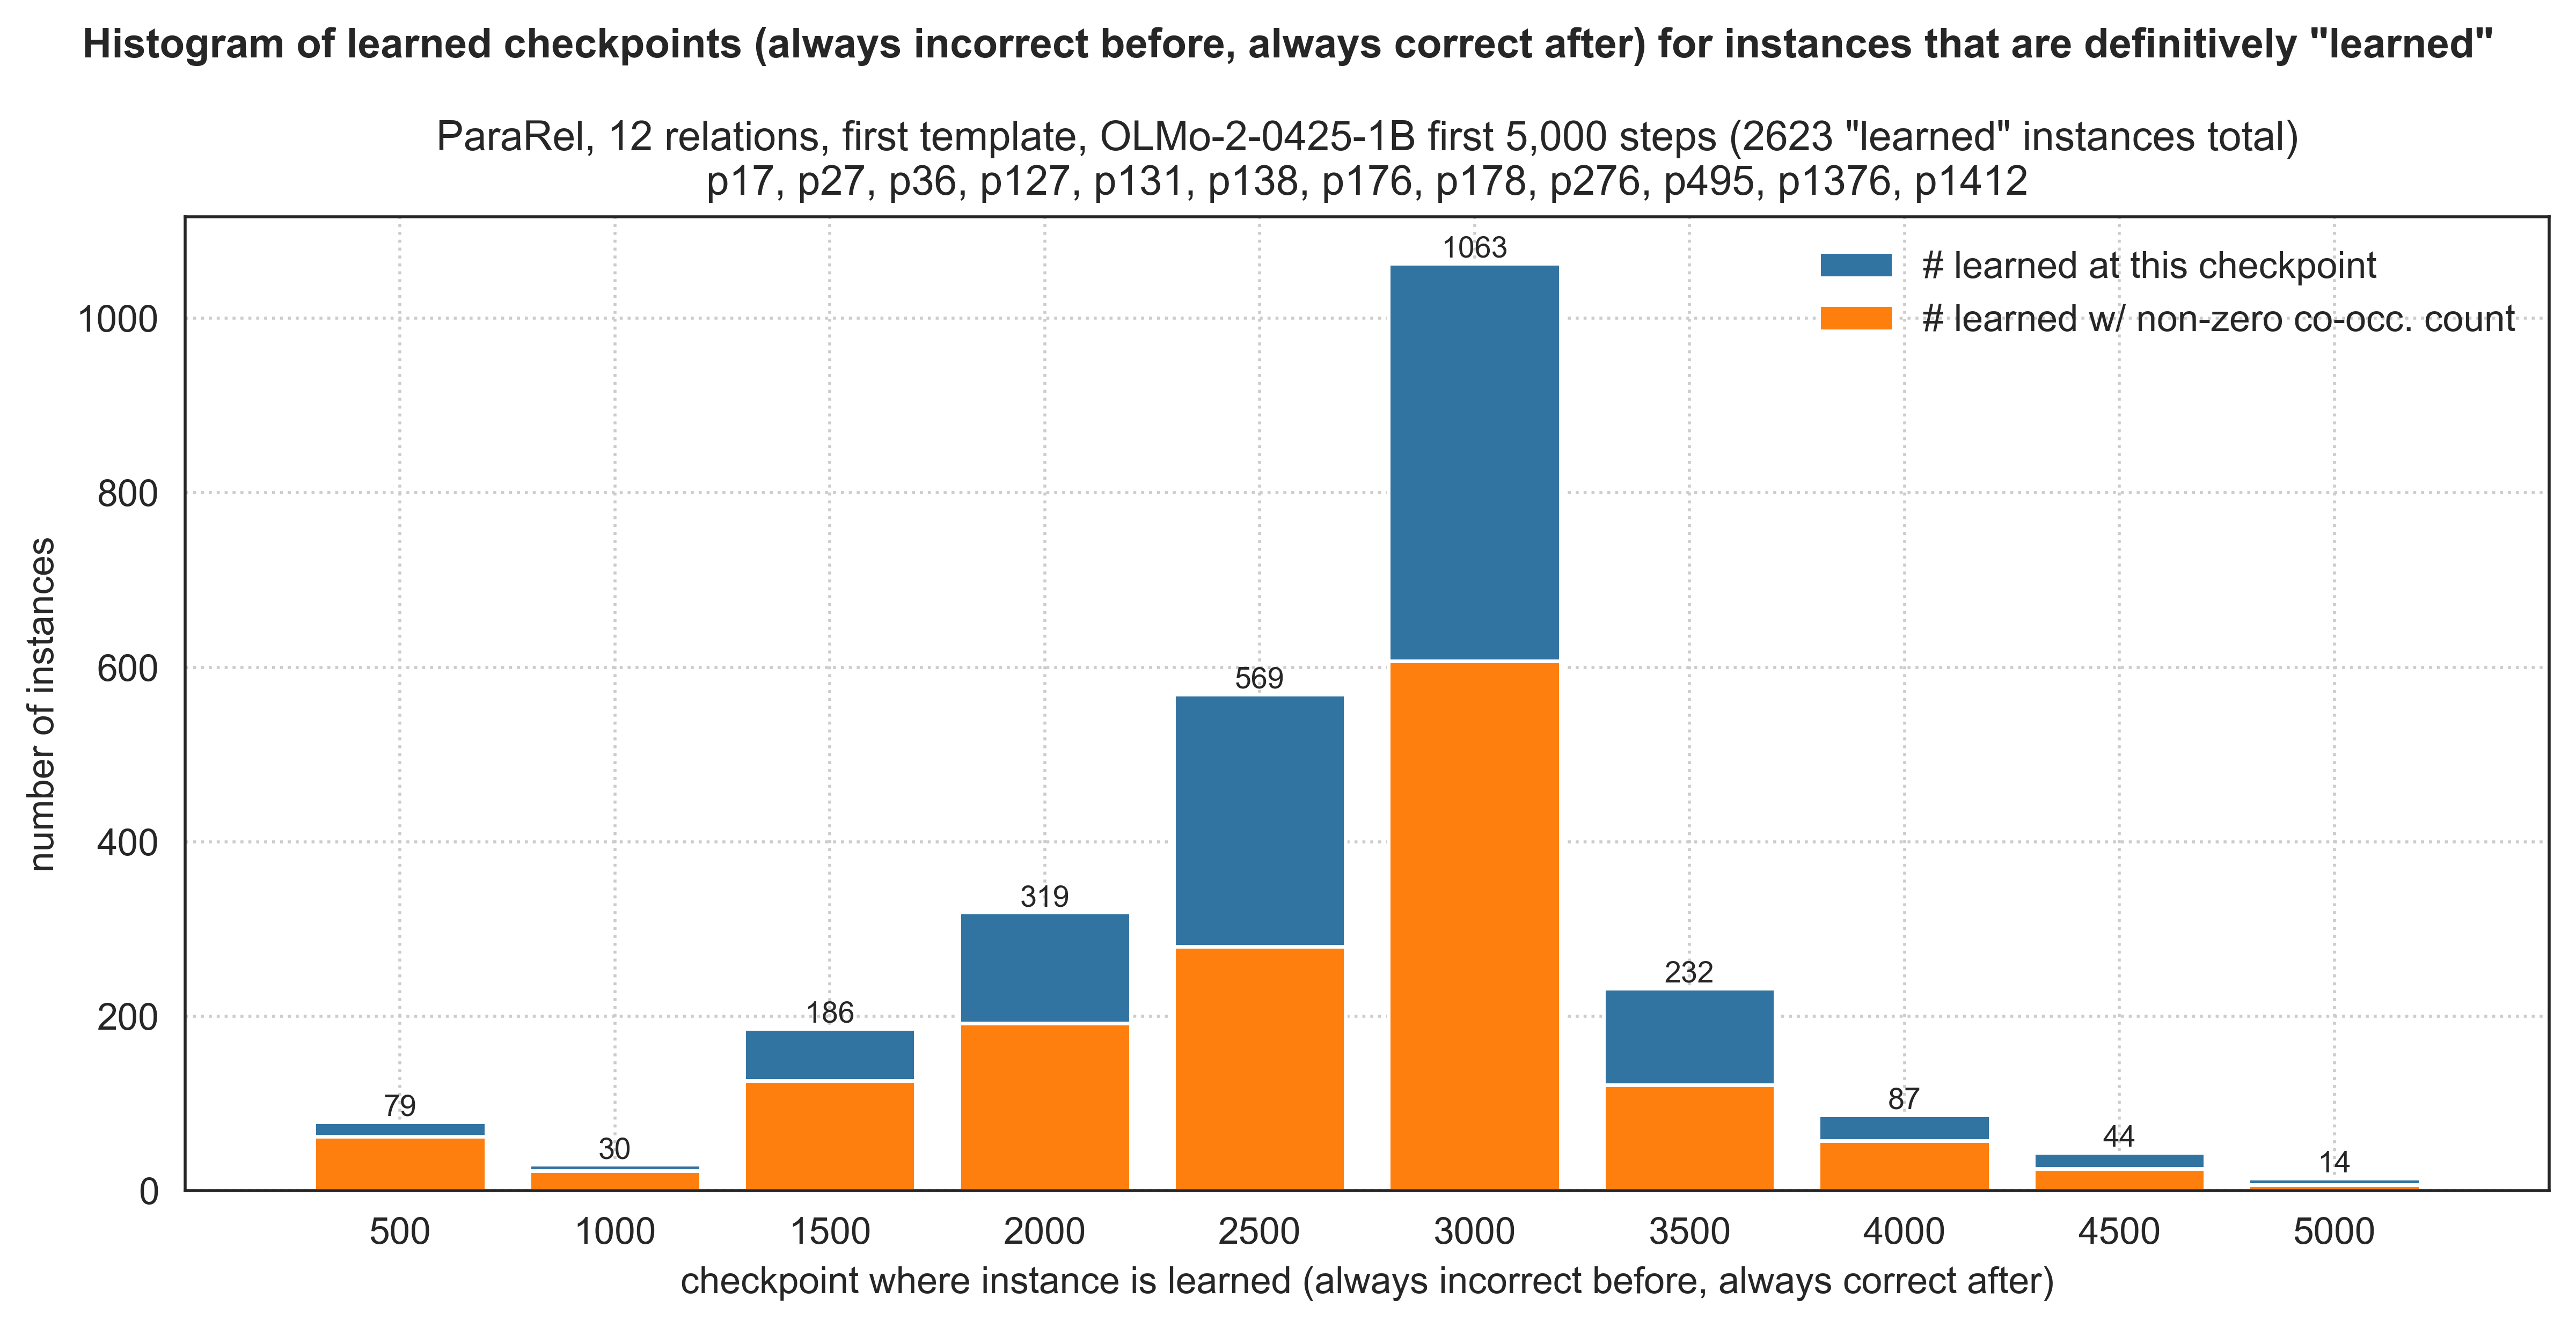

In [21]:
plt.figure(figsize=(9.7, 5))

print(binned_learned_ckpts)
print(learned_nonzero_counts)

# plot learned checkpoint histogram, label bars
ax = sns.barplot(x=ckpt_steps[:len(binned_learned_ckpts)],
                 y=binned_learned_ckpts,
                 color="tab:blue",
                 label="# learned at this checkpoint")
ax.bar_label(ax.containers[0], fontsize=8)
plt.bar(np.arange(len(binned_learned_ckpts)),
        learned_nonzero_counts,
        color="tab:orange",
        label="# learned w/ non-zero co-occ. count")

# add axis grid, label axes
plt.grid(linestyle="dotted")
plt.xlabel("checkpoint where instance is learned (always incorrect before, "
           "always correct after)")
plt.xticks(np.arange(0, len(binned_learned_ckpts), 1),
           ckpt_steps[:len(binned_learned_ckpts)])
plt.xlim(-1, 10)
plt.ylabel("number of instances")

# add titles, save figure to file
plt.suptitle("Histogram of learned checkpoints (always incorrect before, "
             "always correct after) for instances that are definitively "
             "\"learned\"", fontweight="bold", fontsize=11)
total_count = np.sum(binned_learned_ckpts)
relations_str = ", ".join(relations)
plt.title(f"ParaRel, {len(relations)} relations, first template, OLMo-2-0425-1B first "
          f"5,000 steps ({total_count} \"learned\" instances total)\n{relations_str}",
          fontsize=11)
plt.legend(loc="upper right", ncol=1, frameon=False)
plt.tight_layout()
plt.show()

### Get indices of documents to swap based on ***removing co-occurrences***

In [25]:
curr_step, next_step = 3000, 3500
curr_idx, next_idx = 5, 6
# curr_step, next_step = 2000, 2500
# curr_idx, next_idx = 3, 4

# get pair-doc matrices for current and next steps
pair_doc_matx_curr = pair_doc_matxs[curr_step]
pair_doc_matx_next = pair_doc_matxs[next_step]

# get necessary doc infos of 500 steps each from those with 1000 steps
curr_info_step = 1000 * math.ceil(curr_step / 1000)
print("curr_info_step:", curr_info_step)
next_info_step = 1000 * math.ceil(next_step / 1000)
print("next_info_step:", next_info_step)
start_idx = np.where(doc_info[curr_info_step][:, 0] == 500)[0][0]
doc_info_curr = doc_info[curr_info_step][start_idx:, :]
doc_lengths_curr = doc_info_curr[:, -1] - doc_info_curr[:, -2] + 1
end_idx = np.where(doc_info[next_info_step][:, 0] == 500)[0][0]
doc_info_next = doc_info[next_info_step][:end_idx, :]
doc_lengths_next = doc_info_next[:, -1] - doc_info_next[:, -2] + 1

assert doc_info_curr.shape[0] == pair_doc_matx_curr.shape[1], "curr pair-doc matx incorrect"
assert doc_info_next.shape[0] == pair_doc_matx_next.shape[1], "next pair-doc matx incorrect"

# get instances learned in curr ckpt
inst_idxs_curr = learned_nonzero_count_idxs[curr_idx]

# get indices of documents that match instances learned in curr ckpt
doc_idxs_curr = np.nonzero(
    np.sign(
        np.sum(
            pair_doc_matx_curr[inst_idxs_curr, :],
        axis=0).A1.flatten()
    )
)[0]
print(f"num instances, {curr_step}:", len(inst_idxs_curr))
print(f"num docs, {curr_step}:", len(doc_idxs_curr))
print()

# get instances learned in next ckpt
inst_idxs_next = learned_nonzero_count_idxs[next_idx]

# get indices of documents that match instances learned in next ckpt
doc_idxs_next = np.nonzero(
    np.sign(
        np.sum(
            pair_doc_matx_next[inst_idxs_next, :],
        axis=0).A1.flatten()
    )
)[0]
print(f"num instances, {next_step}:", len(inst_idxs_next))
print(f"num docs, {next_step}:", len(doc_idxs_next))
print()

# get indices of documents in next ckpt that match instances learned in curr ckpt
doc_idxs_curr_in_next = np.nonzero(
    np.sign(
        np.sum(
            pair_doc_matx_next[inst_idxs_curr, :],
        axis=0).A1.flatten()
    )
)[0]
print(f"num docs, {curr_step} in {next_step}:", len(doc_idxs_curr_in_next))
print(f"num docs overlap, {curr_step} in {next_step}:", len(set(doc_idxs_curr_in_next) & set(doc_idxs_next)))
print()

# get extra doc indices (documents in next ckpt that don't match instances
# learned in either curr ckpt or next ckpt)
num_docs_next = pair_doc_matx_next.shape[1]
extra_doc_idxs = sorted(set(list(range(num_docs_next))) -
                        (set(doc_idxs_next) | set(doc_idxs_curr_in_next)))
print(f"num docs {next_step}, total:", pair_doc_matx_next.shape[1])
print(f"num docs {next_step}, extra:", len(extra_doc_idxs))
print()

# add offset to curr doc IDs, since they're from the end of a doc info
doc_idxs_curr = doc_idxs_curr + start_idx

# construct indices dictionary
coocc_indices = dict(
    orig_idxs=doc_idxs_curr,
    orig_inst_idxs=inst_idxs_curr,
    new_idxs=np.array([]),
    new_inst_idxs=np.array([]),
    extra_idxs=extra_doc_idxs,
    relations=relations,
    relation_labels=relation_labels,
    template_idxs=np.array([template_index[rel] for rel in relations]),
)

# save set of original doc indices from curr ckpt, new doc indices from
# next ckpt, and extra doc indices from next ckpt
resdir = os.path.join(os.environ["HOME"], "projects", "pretrain-intervention", "data", "swap_indices")
os.makedirs(resdir, exist_ok=True)
np.savez(os.path.join(resdir, f"doc_idxs_olmo_mix_1124_pararel_12rel_swap_{curr_step}_{next_step}_rm_coocc.npz"),
         **coocc_indices)

curr_info_step: 3000
next_info_step: 4000
num instances, 3000: 607
num docs, 3000: 51341

num instances, 3500: 121
num docs, 3500: 14688

num docs, 3000 in 3500: 51781
num docs overlap, 3000 in 3500: 6866

num docs 3500, total: 1091084
num docs 3500, extra: 1031481



### Get indices of documents to swap based on ***removing occurrences***

In [26]:
curr_step, next_step = 3000, 3500
curr_idx, next_idx = 5, 6
# curr_step, next_step = 2000, 2500
# curr_idx, next_idx = 3, 4

# for occurrences only (not co-occurrences), we use documents from steps 3,000 to 4,000
# (rather than just steps 3,000 to 3,5000) to give us more "extra" documents
pair_doc_matx_curr = pair_doc_matxs[curr_step]
pair_doc_matx_next = sp.sparse.hstack([pair_doc_matxs[next_step], pair_doc_matxs[next_step + 500]])

# get term-doc matrices for curr and next steps, for each relation
term_doc_matxs_curr = dict()
term_doc_matxs_next = dict()
for rel in relations:
    term_doc_matxs_curr[rel] = term_doc_matxs[curr_step][rel]
    term_doc_matxs_next[rel] = sp.sparse.hstack([term_doc_matxs[next_step][rel],
                                                 term_doc_matxs[next_step + 500][rel]])

# get necessary doc infos of 500 steps each from those with 1000 steps
curr_info_step = 1000 * math.ceil(curr_step / 1000)
print("curr_info_step:", curr_info_step)
next_info_step = 1000 * math.ceil(next_step / 1000)
print("next_info_step:", next_info_step)
curr_start_idx = np.where(doc_info[curr_info_step][:, 0] == 500)[0][0]
doc_info_curr = doc_info[curr_info_step][curr_start_idx:, :]
doc_lengths_curr = doc_info_curr[:, -1] - doc_info_curr[:, -2] + 1
doc_info_next = doc_info[next_info_step]
doc_lengths_next = doc_info_next[:, -1] - doc_info_next[:, -2] + 1

# sanity check that number of documents in doc info matrices, pair-doc
# matrices, and term-doc matrices are all the same
assert doc_info_curr.shape[0] == pair_doc_matx_curr.shape[1], "curr pair-doc matx incorrect"
for rel in relations:
    assert doc_info_curr.shape[0] == term_doc_matxs_curr[rel].shape[1], f"curr term-doc matx for {rel} incorrect"
assert doc_info_next.shape[0] == pair_doc_matx_next.shape[1], "next pair-doc matx incorrect"
for rel in relations:
    assert doc_info_next.shape[0] == term_doc_matxs_next[rel].shape[1], f"next term-doc matx for {rel} incorrect"

# get indices of instances learned in current checkpoint
inst_idxs_curr = learned_nonzero_count_idxs[curr_idx]
print(f"num instances, {curr_step}:", len(inst_idxs_curr))

# get indices of documents that match instances learned in current checkpoint
# based on occurrence of either subject or object (can only focus on documents
# where terms occur, since documents where terms co-occur are a subset of them)
occurrences = list()
doc_masks_curr = list()
for idx in inst_idxs_curr:
    rel = str(relation_labels[idx])
    start = np.where(relation_labels == rel)[0][0]
    subj_idx, obj_idx = term_idxs[rel][idx - start]
    occurrence_mask = term_doc_matxs_curr[rel][subj_idx].toarray().flatten() \
                      + term_doc_matxs_curr[rel][obj_idx].toarray().flatten()
    doc_masks_curr.append(occurrence_mask)
    occurrences.append(np.sum(np.sign(occurrence_mask)))
occurrences = np.array(occurrences)

# remove instances with the most occurrences, they mess things up
for _ in range(5):
    most_occ_idx = np.argmax(occurrences)
    print(f"removing instance at index {most_occ_idx} with {occurrences[most_occ_idx]} occurrences")
    occurrences = np.concatenate((occurrences[:most_occ_idx], occurrences[most_occ_idx+1:]))
    inst_idxs_curr = np.concatenate((inst_idxs_curr[:most_occ_idx], inst_idxs_curr[most_occ_idx+1:]))
    doc_masks_curr = [doc_masks_curr[i] for i in range(len(doc_masks_curr)) if i != most_occ_idx]
print(f"num instances remaining, {curr_step}:", len(inst_idxs_curr))

# sum across doc masks for all instances
doc_mask_curr = doc_masks_curr[0]
for elem in doc_masks_curr[1:]:
    doc_mask_curr += elem

doc_idxs_curr = np.array(sorted(set(np.nonzero(np.sign(doc_mask_curr))[0])))
print(f"num matching docs, {curr_step}:", len(doc_idxs_curr))

# get indices of documents in next checkpoint that match instances learned in
# current checkpoint, based on occurrence of either subject or object
doc_mask_curr_in_next = np.zeros(doc_info_next.shape[0])
for idx in inst_idxs_curr:
    rel = str(relation_labels[idx])
    start = np.where(relation_labels == rel)[0][0]
    subj_idx, obj_idx = term_idxs[rel][idx - start]
    doc_mask_curr_in_next += term_doc_matxs_next[rel][subj_idx].toarray().flatten()
    doc_mask_curr_in_next += term_doc_matxs_next[rel][obj_idx].toarray().flatten()

doc_idxs_curr_in_next = np.array(sorted(set(np.nonzero(np.sign(doc_mask_curr_in_next))[0])))
print(f"num matching docs, {curr_step} in {next_step}:", len(doc_idxs_curr_in_next))

# get extra doc indices (documents in next checkpoint that don't match
# instances learned in current checkpoint)
num_docs_next = pair_doc_matx_next.shape[1]
extra_doc_idxs = sorted(set(list(range(num_docs_next))) - set(doc_idxs_curr_in_next))
print(f"num docs {next_step}, total:", pair_doc_matx_next.shape[1])
print(f"num docs {next_step}, extra:", len(extra_doc_idxs))
print()

# add offset to curr doc IDs, since they're from the end of a doc info
doc_idxs_curr = doc_idxs_curr + curr_start_idx

# construct indices dictionary
occ_indices = dict(
    orig_idxs=doc_idxs_curr,
    orig_inst_idxs=inst_idxs_curr,
    new_idxs=np.array([]),
    new_inst_idxs=np.array([]),
    extra_idxs=extra_doc_idxs,
    relations=relations,
    relation_labels=relation_labels,
    template_idxs=np.array([template_index[rel] for rel in relations]),
)

# save set of original doc indices from curr ckpt, new doc indices from
# next ckpt, and extra doc indices from next ckpt
resdir = os.path.join(os.environ["HOME"], "projects", "pretrain-intervention", "data", "swap_indices")
os.makedirs(resdir, exist_ok=True)
np.savez(os.path.join(resdir, f"doc_idxs_olmo_mix_1124_pararel_12rel_swap_{curr_step}_{next_step}_rm_occ.npz"),
         **occ_indices)
print("indices saved")

curr_info_step: 3000
next_info_step: 4000
num instances, 3000: 607
removing instance at index 174 with 124214 occurrences
removing instance at index 187 with 83687 occurrences
removing instance at index 19 with 43265 occurrences
removing instance at index 558 with 43265 occurrences
removing instance at index 552 with 43258 occurrences
num instances remaining, 3000: 602
num matching docs, 3000: 428944
num matching docs, 3000 in 3500: 856830
num docs 3500, total: 2179581
num docs 3500, extra: 1322751

indices saved


### Get indices of documents to swap based on ***adding co-occurrences***

In [27]:
curr_step, next_step = 3000, 3500
curr_idx, next_idx = 5, 6
# curr_step, next_step = 2000, 2500
# curr_idx, next_idx = 3, 4

# get pair-doc matrices for current and next steps
pair_doc_matx_curr = pair_doc_matxs[curr_step]
pair_doc_matx_next = pair_doc_matxs[next_step]

# get necessary doc infos of 500 steps each from those with 1000 steps
curr_info_step = 1000 * math.ceil(curr_step / 1000)
print("curr_info_step:", curr_info_step)
next_info_step = 1000 * math.ceil(next_step / 1000)
print("next_info_step:", next_info_step)
curr_start_idx = np.where(doc_info[curr_info_step][:, 0] == 500)[0][0]
doc_info_curr = doc_info[curr_info_step][curr_start_idx:, :]
doc_lengths_curr = doc_info_curr[:, -1] - doc_info_curr[:, -2] + 1
next_end_idx = np.where(doc_info[next_info_step][:, 0] == 500)[0][0]
doc_info_next = doc_info[next_info_step][:next_end_idx, :]
doc_lengths_next = doc_info_next[:, -1] - doc_info_next[:, -2] + 1

assert doc_info_curr.shape[0] == pair_doc_matx_curr.shape[1], "curr pair-doc matx incorrect"
assert doc_info_next.shape[0] == pair_doc_matx_next.shape[1], "next pair-doc matx incorrect"

# get instances learned in next ckpt
inst_idxs_next = learned_nonzero_count_idxs[next_idx]

# get indices of documents that match instances learned in next ckpt
doc_idxs_next = np.nonzero(
    np.sign(
        np.sum(
            pair_doc_matx_next[inst_idxs_next, :],
        axis=0).A1.flatten()
    )
)[0]
print(f"num instances, {next_step}:", len(inst_idxs_next))
print(f"num docs, {next_step}:", len(doc_idxs_next))
print()

# get indices of documents in curr ckpt that match instances learned
# in next ckpt (these are documents that we DO NOT want to replace)
doc_idxs_next_in_curr = np.nonzero(
    np.sign(
        np.sum(
            pair_doc_matx_curr[inst_idxs_next, :],
        axis=0).A1.flatten()
    )
)[0]
print(f"num docs, {next_step} in {curr_step}:", len(doc_idxs_next_in_curr))
print()

# get indices of documents in curr ckpt that DO NOT match instances in
# next ckpt, set as "orig" doc indices (ones that are OK to replace)
num_docs_curr = pair_doc_matx_curr.shape[1]
orig_doc_idxs = sorted(set(list(range(num_docs_curr))) - set(doc_idxs_next_in_curr))
print(f"num docs {curr_step}, total:", pair_doc_matx_curr.shape[1])
print(f"num docs {curr_step}, \"orig\" (OK to replace):", len(orig_doc_idxs))

# add offset to "orig" doc IDs, since they're from the end of a doc info
orig_doc_idxs = orig_doc_idxs + curr_start_idx

# construct indices dictionary
add_coocc_indices = dict(
    orig_idxs=orig_doc_idxs,
    orig_inst_idxs=np.array([]),
    new_idxs=doc_idxs_next,
    new_inst_idxs=inst_idxs_next,
    extra_idxs=np.array([]),
    relations=relations,
    relation_labels=relation_labels,
    template_idxs=np.array([template_index[rel] for rel in relations]),
)

# save set of original doc indices from curr ckpt (docs that are OK to replace)
# and new doc indices from next ckpt
resdir = os.path.join(os.environ["HOME"], "projects", "pretrain-intervention", "data", "swap_indices")
os.makedirs(resdir, exist_ok=True)
np.savez(os.path.join(resdir, f"doc_idxs_olmo_mix_1124_pararel_12rel_swap_{curr_step}_{next_step}_add_coocc.npz"),
         **add_coocc_indices)

curr_info_step: 3000
next_info_step: 4000
num instances, 3500: 121
num docs, 3500: 14688

num docs, 3500 in 3000: 14364

num docs 3000, total: 1090385
num docs 3000, "orig" (OK to replace): 1076021
